# Data Vault Demo (Quant, can also score own portfolio)

The basic concept of the Data Vault is that when a user authenticates themself, they receive an engine that gives them access to all the data (rows, columns, tables, schema, etc.) for which they are authorized.  Users who can authenticate themselves for multiple roles can use those roles simultaneously.  We are keeping in mind the importance of Data Lineage Management (tracked by issue https://github.com/os-climate/os_c_data_commons/issues/50) but is not treated as part of this particular prototype.

The steps of this demo are:

1. **Authenticate and acquire SQLAlchemy engine**
    1. Dev engine sees all
    2. **Quant engine can do temp scoring but not see fundamental company info**
    3. User engine can use temp scoring but not see cumulative emissions nor overshoot info
2. With Dev engine, construct Vaults for:
    1. Fundamental corporate financial information
    2. Corporate emissions data (base year, historical)
    3. Corporate target data (start year, end year, target start value, target end value)
    4. Sector benchmark data (production, CO2e intensity)
3. Dev Engine: Visualize projected emissions (targets and trajectories) and calculate cumulative emissions
4. **Quant Engine: Using calculated cumulative emmisions, visualize per-company trajectory and target temperature scores**
5. User Engine: Using consensus probability scoring and own portfolio data (ISIN, position value)
    1. Calculate publishable per-company temperature alignment score
    2. Based on aggregate corporate and portfolio information, produce weighting scores to yield overall portfolio alignment score

In [1]:
import os
import pathlib
from dotenv import load_dotenv
import osc_ingest_trino as osc
import trino
from sqlalchemy.engine import create_engine

import json
import pandas as pd
from pint_pandas import PintArray
from numpy.testing import assert_array_equal
import ITR

# from ITR.portfolio_aggregation import PortfolioAggregationMethod
# from ITR.temperature_score import TemperatureScore
# from ITR.configs import ColumnsConfig, TemperatureScoreConfig
# from ITR.data.data_warehouse import DataWarehouse
from ITR.data.vault_providers import VaultCompanyDataProvider, VaultProviderProductionBenchmark, \
    VaultProviderIntensityBenchmark, DataVaultWarehouse
# from ITR.interfaces import ICompanyData, EScope, ETimeFrames, PortfolioCompany, IEIBenchmarkScopes, \
#     IProductionBenchmarkScopes
from ITR.interfaces import EScope, IProductionBenchmarkScopes, IEIBenchmarkScopes
from ITR.data.osc_units import ureg, Q_, PA_

# Load some standard environment variables from a dot-env file, if it exists.
# If no such file can be found, does not fail, and so allows these environment vars to
# be populated in some other way
dotenv_dir = os.environ.get('CREDENTIAL_DOTENV_DIR', os.environ.get('PWD', '/opt/app-root/src'))
dotenv_path = pathlib.Path(dotenv_dir) / 'credentials.env'
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path=dotenv_path,override=True)

/opt/app-root/lib64/python3.8/site-packages/openscm_units/_unit_registry.py:471: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for label, val in metric_conversion.iteritems():


using connect string: trino://MichaelTiemannOSC@trino-secure-odh-trino.apps.odh-cl2.apps.os-climate.org:443/osc_datacommons_dev/demo_dv


### Step 1: Initialize Vault user 'Quant', which has limited visibility into corporate financial, production, and target data

### The ITR module provides Vault objects that coordinate the interaction of Dev, Quant, and User roles.

The SQLAlchemy engines mediate the actual interaction with the Data Vault.

In [2]:
sqlstring = 'trino://{user}@{host}:{port}/'.format(
    user = os.environ['TRINO_USER_USER2'],
    host = os.environ['TRINO_HOST'],
    port = os.environ['TRINO_PORT']
)

ingest_catalog = 'osc_datacommons_dev'
ingest_schema = 'demo_dv'
itr_prefix = 'itr_'

sqlargs = {
    'auth': trino.auth.JWTAuthentication(os.environ['TRINO_PASSWD_USER2']),
    'http_scheme': 'https',
    'catalog': ingest_catalog,
    'schema': ingest_schema,
}

engine_quant = create_engine(sqlstring, connect_args = sqlargs)
print("connecting with engine " + str(engine_quant))
osc._do_sql(f"show tables in {ingest_schema}", engine_quant, verbose=True)

connecting with engine Engine(trino://os-climate-user2@trino-secure-odh-trino.apps.odh-cl2.apps.os-climate.org:443/)
show tables in demo_dv
[('itr_benchmark_ei',), ('itr_benchmark_prod',), ('itr_company_data',), ('itr_cumulative_budget_1',), ('itr_cumulative_emissions',), ('itr_emissions_data',), ('itr_fundamental_data',), ('itr_overshoot_ratios',), ('itr_production_data',), ('itr_target_data',), ('itr_temperature_scores',), ('itr_trajectory_data',)]


[('itr_benchmark_ei',),
 ('itr_benchmark_prod',),
 ('itr_company_data',),
 ('itr_cumulative_budget_1',),
 ('itr_cumulative_emissions',),
 ('itr_emissions_data',),
 ('itr_fundamental_data',),
 ('itr_overshoot_ratios',),
 ('itr_production_data',),
 ('itr_target_data',),
 ('itr_temperature_scores',),
 ('itr_trajectory_data',)]

### The ITR module provides Vault objects that coordinate the interaction of Dev, Quant, and User roles.

The SQLAlchemy engines mediate the actual interaction with the Data Vault.

### Steps 2 & 3: Done in Dev part of vault_demo_n0

### Step 4: Use Quant engine to access and visualize temperature scores

When the Data Vault is ready to be implemented, we can demonstrate that the Quant engine does not have access to primary company data (neither financial nor production)

Show that we *cannot* access fundamental company data (cannot show until op1st team changes permissions)

In [3]:
vault_company_data = VaultCompanyDataProvider (engine_quant,
                                               company_table=f'{itr_prefix}company_data',
                                               target_table=None,
                                               trajectory_table=None,
                                               company_schema='demo_dv',
                                               column_config=None)


select C.company_name, C.company_id from demo_dv.itr_company_data C left join demo_dv.itr_target_data EI on EI.company_name=C.company_name
where EI.ei_s1_by_year is NULL and EI.ei_s1s2_by_year is NULL and EI.ei_s1s2s3_by_year is NULL



2023-03-13 19:04:20,490 - ITR.data.vault_providers - ERROR - Provide either historic emissions data or projections for companies with IDs []


[]


In [4]:
vault_warehouse = DataVaultWarehouse(engine_quant,
                                     company_data=None,
                                     benchmark_projected_production=None,
                                     benchmarks_projected_ei=None,
                                     ingest_schema = 'demo_dv',
                                     itr_prefix=itr_prefix,
                                     column_config=None)

vault_warehouse.quant_init(engine_quant, company_data=vault_company_data, ingest_schema='demo_dv', itr_prefix=itr_prefix)

In [5]:
ureg.setup_matplotlib(True)
%matplotlib inline

In [6]:
# Because this DF comes from reading a Trino table, and because columns must be unqiue, we don't have to enumerate to ensure we properly handle columns with duplicated names

def requantify_df(df: pd.DataFrame, typemap: dict) -> pd.DataFrame:
    units_col = None
    columns_not_found = [k for k in typemap.keys() if k not in df.columns]
    if columns_not_found:
        print(f"columns {columns_not_found} not found in DataFrame")
        raise ValueError
    columns_reversed = reversed(df.columns)
    for col in columns_reversed:
        if col.endswith("_units"):
            if units_col:
                print(f"Column {units_col} follows {col} without intervening value column")
                # We expect _units column to follow a non-units column
                raise ValueError
            units_col = col
            continue
        if units_col:
            if col + '_units' != units_col:
                print(f"Excpecting column name {col}_units but saw {units_col} instead")
                raise ValueError
            if (df[units_col]==df[units_col][0]).all():
                # We can make a PintArray since column is of homogeneous type
                new_col = PintArray(df[col], dtype=f"pint[{ureg(df[units_col][0]).u}]")
            else:
                # Make a pd.Series of Quantity in a way that does not throw UnitStrippedWarning
                new_col = pd.Series(data=df[col], name=col) * pd.Series(data=df[units_col].map(lambda x: ureg(x).u), name=col)
            if col in typemap.keys():
                new_col = new_col.astype(typemap[col])
            df = df.drop(columns=units_col)
            df[col] = new_col
            units_col = None
    return df

Show that we *can* access both cumulative emissions (input) and temperature scores (output)

In [7]:
sql_temp_score_df = pd.read_sql_table(f"{itr_prefix}temperature_scores", engine_quant)

/opt/app-root/lib64/python3.8/site-packages/pandas/io/sql.py:1770: SAWarning: index key 'partition' was not located in columns for table 'itr_temperature_scores'
  tbl = Table(
/opt/app-root/lib64/python3.8/site-packages/pandas/io/sql.py:1770: SAWarning: index key 'record_count' was not located in columns for table 'itr_temperature_scores'
  tbl = Table(
/opt/app-root/lib64/python3.8/site-packages/pandas/io/sql.py:1770: SAWarning: index key 'file_count' was not located in columns for table 'itr_temperature_scores'
  tbl = Table(
/opt/app-root/lib64/python3.8/site-packages/pandas/io/sql.py:1770: SAWarning: index key 'total_size' was not located in columns for table 'itr_temperature_scores'
  tbl = Table(
/opt/app-root/lib64/python3.8/site-packages/pandas/io/sql.py:1770: SAWarning: index key 'data' was not located in columns for table 'itr_temperature_scores'
  tbl = Table(


In [8]:
temp_score_df = requantify_df(sql_temp_score_df, typemap={'trajectory_temperature_score':'pint[delta_degC]', 'target_temperature_score':'pint[delta_degC]'})
temp_score_df = temp_score_df[~temp_score_df.company_id.isin(['US6362744095+Gas Utilities', 'US0236081024+Gas Utilities', 'CA87807B1076+Gas', 'CA87807B1076+Oil', 'NO0010657505'])]
temp_score_df

,company_name,company_id,source,scope,benchmark,trajectory_temperature_score,target_temperature_score
0,Southern Co.,US8425871071,demo_dv,S1+S2,benchmark_1,1.5082412298405619,1.5769538866985213
1,"Consolidated Edison, Inc.",US2091151041,demo_dv,S1+S2,benchmark_1,1.3555940508382491,1.3008482040462395
2,Entergy Corp.,US29364G1031,demo_dv,S1+S2,benchmark_1,1.5812683487668127,1.3813135109788874
3,"PNM Resources, Inc.",US69349H1077,demo_dv,S1+S2,benchmark_1,1.5722855532188582,1.4640496254260151
4,Portland General Electric Co.,US7365088472,demo_dv,S1+S2,benchmark_1,1.6617823474355569,1.3566300571211931
5,Vistra Corp.,US92840M1027,demo_dv,S1+S2,benchmark_1,2.7003873297686103,2.002280372395396
6,CARPENTER TECHNOLOGY CORP,US1442851036,demo_dv,S1+S2,benchmark_1,2.469920539754428,1.7555490411756596
7,Alliant Energy,US0188021085,demo_dv,S1+S2,benchmark_1,1.4834956587681745,1.5059809838337372
8,"American Electric Power Co., Inc.",US0255371017,demo_dv,S1+S2,benchmark_1,1.44992993840394,1.4772851133417573
9,FirstEnergy Corp.,US3379321074,demo_dv,S1+S2,benchmark_1,1.3385761018918498,1.3531501625661222


In [9]:
plottable_df = temp_score_df[['company_name', 'trajectory_temperature_score', 'target_temperature_score']].sort_values('company_name').set_index('company_name')
plottable_df = pd.concat([plottable_df, (plottable_df['trajectory_temperature_score'] + plottable_df['target_temperature_score'])/2.0], axis=1)
plottable_df.columns = ['trajectory_temperature_score', 'target_temperature_score', 'average_score']
plottable_df = plottable_df.T

In [10]:
plottable_df.applymap(lambda x: x.m).dropna(axis=1, how='all').iloc[:, 0:5]

company_name,AES Corp.,Algonquin Power & Utilities Corp.,Alliant Energy,Ameren Corp.,"American Electric Power Co., Inc."
trajectory_temperature_score,1.583138,1.739970,1.483496,2.293309,1.449930
target_temperature_score,1.486880,1.755953,1.505981,1.640783,1.477285
average_score,1.535009,1.747962,1.494738,1.967046,1.463608


<AxesSubplot: >

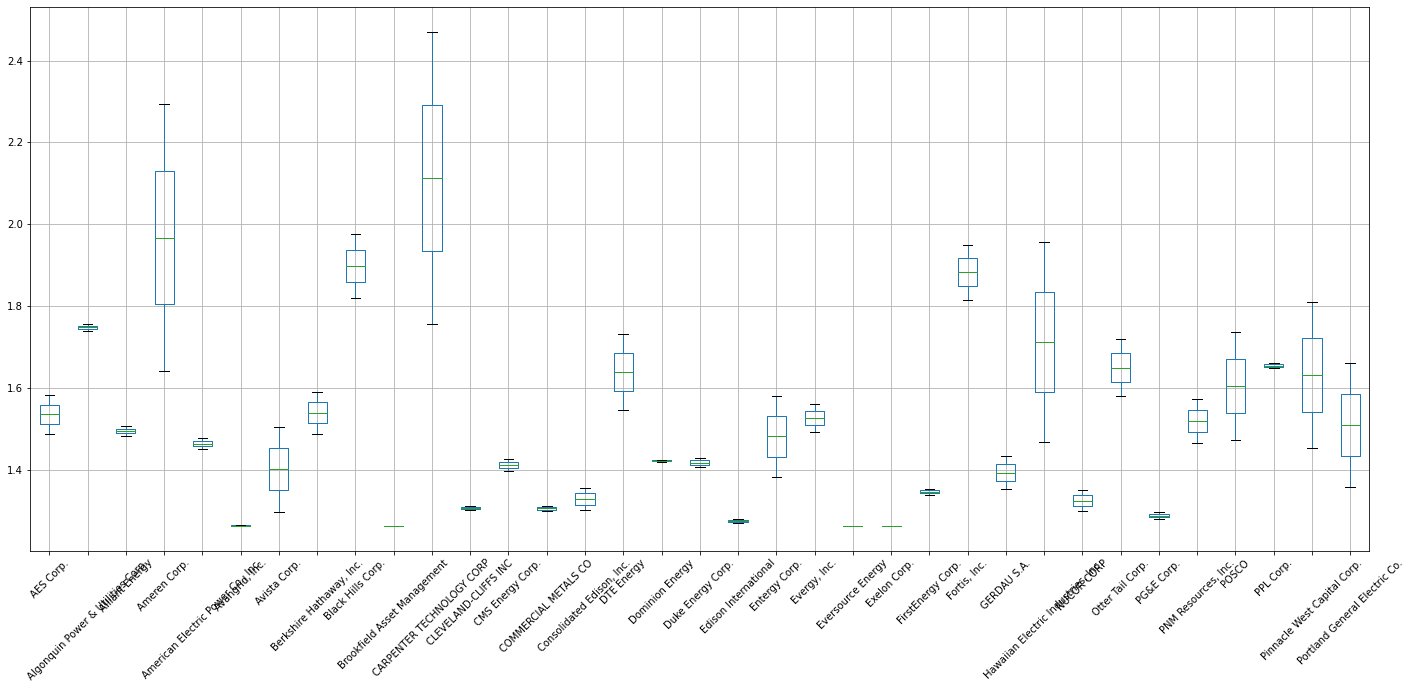

In [11]:
# Must plot the first few columns, but then plot 1/3rd of the companies so as not to over-clutter the graph
plottable_df.applymap(lambda x: x.m).dropna(axis=1, how='all').iloc[:, 0:35].boxplot(figsize=(24,10), rot=45)

### Step 5: Show per-company temperature score and weighted portfolio alignment score

Portfolio weighting scores (which ultimately influence portfolio alignment score) include:
* WATS (size of portfolio company positions used as weights)
* TETS (size of total emissions of portfolio companies used as weights)
* Financial fundamental weights:
    * Market Cap
    * Enterprise Value
    * Assets
    * Revenues

We can pass a list of company IDs to the Data Vault to get back a sum without exposing granular data

Show that we *can also* access both cumulative emissions (input) and temperature scores (output)

In [12]:
portfolio_df = pd.read_csv("data/mdt-20220116-portfolio.csv", encoding="iso-8859-1", sep=';', index_col='company_id')
portfolio_df

,company_name,company_lei,investment_value
company_id,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812
...,...,...,...
US8873991033,TIMKENSTEEL CORP,549300QZTZWHDE9HJL14,10000000
US88830M1027,TITAN INTERNATIONAL INC,254900CXRGBE7C4B5A06,10000000
US9129091081,UNITED STATES STEEL CORP,JNLUVFYJT1OZSIQ24U47,10000000


### Calculate portfolio alignment temperature score based on WATS

We can do this with information exclusive to the user space (and the probability-adjusted temperature scores)

Note that companies with no production information (such as TITAL INTERNATIONAL INC and UNIVERSAL STAINLESS & ALLOY PRODUCTS INC will show NaN (Not a Number) as a score.

In [13]:
# PA_SCORE means "Probability-Adjusted" Temperature Score
portfolio_df['pa_score'] = vault_warehouse.get_pa_temp_scores(probability=0.5, company_ids=portfolio_df.index.values).astype('pint[delta_degC]')

In [14]:
# portfolio_df[portfolio_df.company_name=='POSCO']
portfolio_df.dropna(inplace=True)
portfolio_df.sort_values(by='company_name')

,company_name,company_lei,investment_value,pa_score
company_id,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,1.5350088173907537
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,1.7479615344904824
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,1.494738321300956
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,1.9670458989359405
US0255371017,"American Electric Power Co., Inc.",1B4S6S7G0TW5EE83BO58,45520637,1.4636075258728485
US05351W1036,"Avangrid, Inc.",549300OX0Q38NLSKPB49,10049068,1.2634482190308003
US05379B1070,Avista Corp.,Q0IK63NITJD6RJ47SW96,2804211,1.4010426933807054
US1442851036,CARPENTER TECHNOLOGY CORP,DX6I6ZD3X5WNNCDJKP85,10000000,2.1127347904650438
US1258961002,CMS Energy,549300IA9XFBAGNIBW29,9153135,1.4118106074040457


In [15]:
weight_for_WATS = portfolio_df['investment_value'].sum()
weight_for_WATS

627818278

In [16]:
portfolio_df['WATS_weight'] = portfolio_df['pa_score'] * (portfolio_df['investment_value'] / weight_for_WATS)
portfolio_df.head()

,company_name,company_lei,investment_value,pa_score,WATS_weight
company_id,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,1.5350088173907537,0.01063876350966824
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,1.7479615344904824,0.0062036767775159865
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,1.494738321300956,0.009117402601957866
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,1.9670458989359405,0.049872818157475345
US0255371017,"American Electric Power Co., Inc.",1B4S6S7G0TW5EE83BO58,45520637,1.4636075258728485,0.10612043202687074


In [17]:
print(f"Portfolio temperature score based on WATS = {portfolio_df['WATS_weight'].sum()}")

Portfolio temperature score based on WATS = 1.4686959033135665 delta_degree_Celsius


### Calculate portfolio alignment temperature score based on TETS

We need to carefully meld portfolio data with corp fundamental data (in this case, emissions)

In [18]:
portfolio_df['TETS_weight'] = vault_company_data.compute_portfolio_weights(portfolio_df['pa_score'], 2019, 'emissions', EScope.S1S2).astype('pint[delta_degC]')
portfolio_df.head()

,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight
company_id,,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,1.5350088173907537,0.01063876350966824,1.0849933534112957e-07
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,1.7479615344904824,0.0062036767775159865,3.5391609901595476e-08
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,1.494738321300956,0.009117402601957866,8.787456932352129e-08
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,1.9670458989359405,0.049872818157475345,7.520484173433357e-07
US0255371017,"American Electric Power Co., Inc.",1B4S6S7G0TW5EE83BO58,45520637,1.4636075258728485,0.10612043202687074,5.108819415703074e-07


In [19]:
print(f"Portfolio temperature score based on TETS = {portfolio_df['TETS_weight'].sum()}")

Portfolio temperature score based on TETS = 1.5370187660004366 delta_degree_Celsius


### Calculate portfolio alignment temperature score based on MOTS, EOTS, ECOTS, AOTS, and ROTS

* MOTS = market cap weights
* EOTS = enterprise value weights
* ECOTS = EVIC weights
* AOTS = asset weights
* ROTS = revenue weights

In [20]:
portfolio_df.dtypes

company_name                            object
company_lei                             object
investment_value                         int64
pa_score            pint[delta_degree_Celsius]
WATS_weight         pint[delta_degree_Celsius]
TETS_weight         pint[delta_degree_Celsius]
dtype: object

In [21]:
weighting_dict = {
    'MOTS': 'company_market_cap',
    'EOTS': 'company_ev',
    'ECOTS': 'company_evic',
    'AOTS': 'company_total_assets',
    'ROTS': 'company_revenue',
}

for k, v in weighting_dict.items():
    weight_column = f"{k}_weight"
    portfolio_df[weight_column] = vault_company_data.compute_portfolio_weights(portfolio_df['pa_score'], 2019, v, EScope.S1S2)
    print(f"Portfolio temperature score based on {k} = {portfolio_df[weight_column].sum()}")

portfolio_df

Portfolio temperature score based on MOTS = 1.4584327499028584 delta_degree_Celsius
Portfolio temperature score based on EOTS = 1.4582657692201524 delta_degree_Celsius
Portfolio temperature score based on ECOTS = 1.4586193391103974 delta_degree_Celsius
Portfolio temperature score based on AOTS = 1.4765667685306014 delta_degree_Celsius
Portfolio temperature score based on ROTS = 1.4788400390399583 delta_degree_Celsius


,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight,MOTS_weight,EOTS_weight,ECOTS_weight,AOTS_weight,ROTS_weight
company_id,,,,,,,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,1.5350088173907537,0.01063876350966824,1.0849933534112957e-07,0.026813687313967886,0.015047363588390171,0.028906698860640012,0.03810364807444924,0.04119215367013356
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,1.7479615344904824,0.0062036767775159865,3.5391609901595476e-08,nan,nan,nan,0.014070565812337867,0.0074805957298406615
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,1.494738321300956,0.009117402601957866,8.787456932352129e-08,0.027863731728960815,0.026838829826973915,0.027479583597722422,0.01841604091410514,0.014360062969410281
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,1.9670458989359405,0.049872818157475345,7.520484173433357e-07,0.058096126405003445,0.0530732954583222,0.0572645869735542,0.04198598907343915,0.03061780388637867
US0255371017,"American Electric Power Co., Inc.",1B4S6S7G0TW5EE83BO58,45520637,1.4636075258728485,0.10612043202687074,5.108819415703074e-07,0.10229365320807321,0.10427105569637042,0.10131347659021739,0.08194430502455104,0.05998537282489031
US05351W1036,"Avangrid, Inc.",549300OX0Q38NLSKPB49,10049068,1.2634482190308003,0.020223172074514538,2.0178677739435216e-10,0.00575810786417228,0.01327295575148269,0.006026676148227397,0.03207851593937174,0.021090250818365353
US05379B1070,Avista Corp.,Q0IK63NITJD6RJ47SW96,2804211,1.4010426933807054,0.006257892562101866,2.069181288404246e-08,0.006638625335650037,0.006686063219231164,0.006559856495611668,0.006286758433578272,0.0049653116313556
US1258961002,CMS Energy,549300IA9XFBAGNIBW29,9153135,1.4118106074040457,0.02058317436244064,1.0326549097915105e-07,0.03709910572190063,0.03858313673055527,0.03684910345299242,0.027951610398129965,0.025452002387053325
US2091151041,"Consolidated Edison, Inc.",54930033SBW53OO8T749,20394113,1.3282211274422444,0.04314607062466655,1.3704118189959661e-08,0.06211256941072521,0.06198482776530401,0.0632324214063408,0.056909653548129505,0.043986145083126926


### Companies for which we lack production data (and thus cannot chart)

In [22]:
portfolio_df[portfolio_df.pa_score.isnull()]

,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight,MOTS_weight,EOTS_weight,ECOTS_weight,AOTS_weight,ROTS_weight
company_id,,,,,,,,,,,


In [23]:
osc._do_sql(f"select * from {ingest_schema}.{itr_prefix}company_data", engine_quant, verbose=False)

[('AES Corp.', '2NUNNB7D43COUIRE5295', 'US00130H1059', 'Electricity Utilities', 'US', 'North America', 'equity', 'USD', 2019, 10870000000.0, 10189000000.0, 10102000000.0, 11131000000.0, 33648000000.0, 1029000000.0, 261000000.0),
 ('Algonquin Power & Utilities Corp.', '549300K5VIUTJXQL7X75', 'US0158577090', 'Electricity Utilities', 'CA', 'North America', 'equity', 'USD', 2019, None, 1624921000.0, None, None, 10911470000.0, 62485000.0, 6500799000.0),
 ('Alliant Energy', '5493009ML300G373MZ12', 'US0188021085', 'Electricity Utilities', 'US', 'North America', 'equity', 'USD', 2019, 11600000000.0, 3647700000.0, 18503600000.0, 18519900000.0, 16700700000.0, 16300000.0, 6919900000.0),
 ('Ameren Corp.', 'XRZQ5S7HYJFPHJ78L959', 'US0236081024', 'Electricity Utilities', 'US', 'North America', 'equity', 'USD', 2019, 18378774986.0, 5910000000.0, 27804774986.0, 27820774986.0, 28933000000.0, 16000000.0, 9442000000.0),
 ('American Electric Power Co., Inc.', '1B4S6S7G0TW5EE83BO58', 'US0255371017', 'Elect